# Analyze and plot methods for hurricane forecast uncertainty
##### author: Elizabeth A. Barnes, Randal J. Barnes and Mark DeMaria
##### version: v0.1.0
##### date: 14 December 2021

```
conda create --name env-hurr-tfp python=3.9
conda activate env-hurr-tfp
pip install tensorflow==2.7.0
pip install tensorflow-probability==0.15.0
pip install --upgrade numpy scipy pandas statsmodels matplotlib seaborn 
pip install --upgrade palettable progressbar2 tabulate icecream flake8
pip install --upgrade keras-tuner sklearn
pip install --upgrade jupyterlab black isort jupyterlab_code_formatter
pip install silence-tensorflow
pip install tqdm
```

Use the command
```python -m pip freeze > requirements.txt```
to make a pip installation list.

In [1]:
import datetime
import os
import pickle
import pprint
import time

import experiment_settings
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import shash
from build_data import build_hurricane_data
from build_model import build_shash_model, build_bnn_model
from custom_loss import compute_shash_NLL, compute_NLL
from custom_metrics import CustomMAE, InterquartileCapture, SignTest
from model_diagnostics import plot_history
from save_model_run import save_model_run
from sklearn import preprocessing
from tensorflow.keras import optimizers
from training_instrumentation import TrainingInstrumentation
from silence_tensorflow import silence_tensorflow
import tensorflow_probability as tfp
from keras.utils.layer_utils import count_params  
import prediction

from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")
silence_tensorflow()
dpiFig = 400

In [2]:
__author__ = "Randal J Barnes and Elizabeth A. Barnes"
__version__ = "17 January 2022"

# EXP_NAME_LIST = ("intensity0_AL72","intensity1_AL72")
# EXP_NAME_LIST = ("intensity2_EPCP48","intensity3_EPCP48")
EXP_NAME_LIST = ("intensity10_EPCP96","intensity11_EPCP96")


DATA_PATH = "data/"
MODEL_PATH = "saved_models/"
FIGURE_PATH = "figures/summary_plots/"

In [3]:
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["figure.dpi"] = 150
np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

## Load the models

In [4]:
for exp_name in EXP_NAME_LIST:
    settings = experiment_settings.get_settings(exp_name)
    RNG_SEED_LIST = np.copy(settings['rng_seed'])

    for rng_seed in RNG_SEED_LIST[0:1]:
        settings['rng_seed'] = rng_seed
        NETWORK_SEED_LIST = [settings["rng_seed"]]
        network_seed = NETWORK_SEED_LIST[0]
        tf.random.set_seed(network_seed)  # This sets the global random seed.  
    
    (
        x_train,
        onehot_train,
        x_val,
        onehot_val,
        x_eval,
        onehot_eval,    
        data_summary,
        df_val,
        df_eval,
    ) = build_hurricane_data(DATA_PATH, settings, verbose=0)  

    if settings["uncertainty_type"] == "bnn":       
        model_name_bnn = (
            exp_name + "_" + settings["uncertainty_type"] + '_' + f"network_seed_{network_seed}_rng_seed_{settings['rng_seed']}"
        )
        pprint.pprint(model_name_bnn)
        
        model_bnn = build_bnn_model(
            x_train,
            onehot_train,
            hiddens=settings["hiddens"],
            output_shape=onehot_train.shape[1],
            ridge_penalty=settings["ridge_param"],
            act_fun=settings["act_fun"],
        )
        model_bnn.load_weights(MODEL_PATH + model_name_bnn + "_weights.h5")

    elif settings["uncertainty_type"][:5] == "shash": 
        model_name_shash = (
            exp_name + "_" + settings["uncertainty_type"] + '_' + f"network_seed_{network_seed}_rng_seed_{settings['rng_seed']}"
        )
        pprint.pprint(model_name_shash)
        
        model_shash = build_shash_model(
            x_train,
            onehot_train,
            hiddens=settings["hiddens"],
            output_shape=onehot_train.shape[1],
            ridge_penalty=settings["ridge_param"],
            act_fun=settings["act_fun"],
        )
        model_shash.load_weights(MODEL_PATH + model_name_shash + "_weights.h5")
        
    


'intensity10_EPCP96_shash3_network_seed_605_rng_seed_605'
'intensity11_EPCP96_bnn_network_seed_605_rng_seed_605'


## Make Model Predictions

In [5]:
runs = 5_000
shash_incs = np.arange(-160,161,1)
shash_cpd = np.zeros((np.shape(x_eval)[0],len(shash_incs)))
shash_med = np.zeros((np.shape(x_eval)[0],))
bnn_cpd = np.zeros((np.shape(x_eval)[0],runs))
tf.random.set_seed(network_seed)

# loop through samples for shash calculation and get PDF for each sample
for j in tqdm(range(0,np.shape(shash_cpd)[0])):
    mu_pred, sigma_pred, gamma_pred, tau_pred = prediction.params( x_eval[np.newaxis,j], model_shash )
    shash_cpd[j,:] = shash.prob(shash_incs, mu_pred, sigma_pred, gamma_pred, tau_pred)    
    shash_med[j]   = shash.median(mu_pred,sigma_pred,gamma_pred,tau_pred)
    
# loop through runs for bnn calculation    
for i in tqdm(range(0,runs)):
    bnn_cpd[:,i] = np.reshape(model_bnn.predict(x_eval),np.shape(bnn_cpd)[0])
     

100%|████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [03:33<00:00, 23.43it/s]


## Plot Results

In [ ]:
raise ValueError('no plotting yet')

In [ ]:
import analysis_plots
import imp
imp.reload(analysis_plots)

f, axs = plt.subplots(2, 2, figsize=(15,10))

# plot sample
ax = axs[0,0]
analysis_plots.plot_sample(ax, onehot_eval, shash_incs, shash_cpd, bnn_cpd)

# plot PITS
ax = axs[0,1]
analysis_plots.plot_pits(ax, x_eval, onehot_eval, model_shash, shash_cpd, bnn_cpd)

# plot median vs median
ax = axs[1,0]
analysis_plots.plot_medians(ax, onehot_eval, shash_cpd, bnn_cpd, shash_med)

# plot NLLs
ax = axs[1,1]
analysis_plots.plot_nlls(ax, x_eval, onehot_eval, model_shash, shash_cpd, bnn_cpd)

plt.tight_layout()

plt.savefig('figures/prediction_plots/comparisonsPanels_' + model_name_shash + '_' + model_name_bnn + '.png', dpi=dpiFig)    
plt.show()

In [ ]:
from numpy.random import default_rng
rng = default_rng(12345)
    
f, axs = plt.subplots(5, 3, figsize=(15,20))
axs = axs.flatten()
random_samples = rng.choice(np.arange(0,onehot_eval.shape[0]),len(axs),replace=False)

for isample, sample in enumerate(random_samples):
    ax = axs[isample]
    analysis_plots.plot_sample(ax, onehot_eval, shash_incs, shash_cpd, bnn_cpd, sample=sample)
    plt.xlim(-80,80)

plt.tight_layout()
plt.savefig('figures/prediction_plots/comparisonsPanelsLotsofSamples_' + model_name_shash + '_' + model_name_bnn + '.png', dpi=dpiFig)    
plt.show()        

## Error analysis

In [ ]:
raise ValueError('no plotting yet')

In [33]:
from scipy import stats

# make predictions
mu_pred, sigma_pred, gamma_pred, tau_pred = prediction.params(x_eval, model_shash)    

# convert y_pred to intensity corrections    
ann_correction  = prediction.percentile_value(mu_pred,sigma_pred,gamma_pred,tau_pred,percentile_frac=.5)
true_correction = df_val['OBDV'].to_numpy()  

# convert to full intensity predictions
cons_intensity  = df_val['VMXC'].to_numpy()
ann_intensity   = cons_intensity + ann_correction
true_intensity  = cons_intensity + true_correction

# compute errors
shash_error  = np.abs(ann_intensity - true_intensity)
cons_error = np.abs(cons_intensity - true_intensity)

# covert shash prediction bounds
shash_low_correction  = prediction.percentile_value(mu_pred,sigma_pred,gamma_pred,tau_pred,percentile_frac=.25)
shash_high_correction = prediction.percentile_value(mu_pred,sigma_pred,gamma_pred,tau_pred,percentile_frac=.75)
iqr                   = shash_high_correction - shash_low_correction

print(stats.spearmanr(iqr,shash_error))
print(stats.pearsonr(iqr,shash_error))

df_eval['iqr'] = iqr
df_eval['shash_error'] = shash_error

SpearmanrResult(correlation=0.20957046225724127, pvalue=1.7212299035409448e-06)
(0.16100249491880747, 0.00025413364995478826)


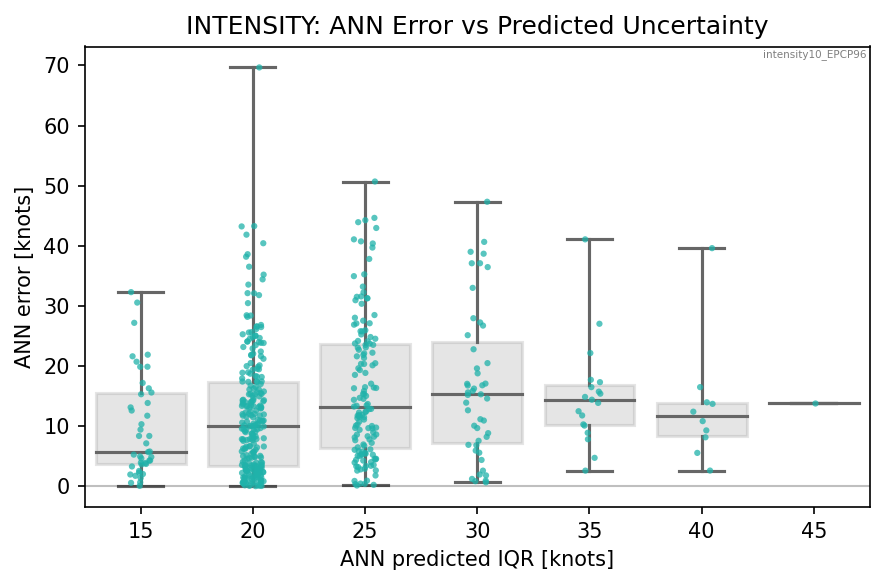

In [28]:
import pandas as pd
from toolbox import custom_round, ceiling_round
import seaborn as sns

ROUND_BASE = 5

df_plot = df_eval.copy()
df_plot['iqr'] = pd.Series(df_plot['iqr']).apply(lambda x: custom_round(x, base=ROUND_BASE))
# df_plot['iqr'] = pd.Series(df_plot['iqr']).apply(lambda x: ceiling_round(x, ceiling=40))
#-----------------------------------------------------------------------------

for xvar in ('iqr',):#('sigma', 'range_66'):
    yvar = 'shash_error'

    plt.figure()
    g = sns.boxplot(
        data=df_plot,
        x=xvar, y=yvar,
        whis=100,
        boxprops={'alpha':.2,
                  'edgecolor': 'gray',
                  'color': 'gray',
                 },
    )
    plt.setp(g.artists, edgecolor = '.4', facecolor='.95')
    plt.setp(g.lines, color='.4')
    ax = sns.stripplot(x=xvar, y=yvar, data=df_plot, color="lightseagreen", size=3.,alpha=.75,)
    plt.axhline(y=0,color='k', alpha=.25, linewidth=1)

    # g.set_xticks((0,1,2,3,4,5,6,7)) # <--- set the ticks first
    # g.set_xticklabels(['5','10','15','20','25','30','35','40+'])    

    plt.ylabel('ANN error [knots]')
    plt.xlabel('ANN predicted IQR [knots]')
    plt.title('INTENSITY: ANN Error vs Predicted Uncertainty')
    plt.tight_layout()

    plt.text(.995, .995, EXP_NAME_LIST[0],
        horizontalalignment='right',
        verticalalignment='top',
        color='tab:gray',
        fontsize=5,
        transform = ax.transAxes)    

    # plt.savefig('figures/proposal_plots/' + MODEL_NAME + '_boxplot_' + xvar + '_' + yvar + '_cleaned_40+.png', dpi=dpiFig)    
    plt.show()